# Paper Replication
- Replication 대상: An Image is Worth 16x16 words: Transformers for Image Recognition at Scale
    - https://arxiv.org/abs/2010.11929

In [1]:
# Setup environment

import pathlib
import torch
import torchvision

from going_modular import *

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device: {device}')

# download data
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
train_dir = image_path / "train"
test_dir = image_path / "test"

print(f'train_dir: {train_dir}')
print(f'test_dir: {test_dir}')

# prepare DataLoader
img_size = 224
batch_size = 32

manual_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor()
])
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform = manual_transform,
    batch_size=batch_size,
)
print(f'len(train_dataloader): {len(train_dataloader)}')
print(f'len(test_dataloader): {len(test_dataloader)}')
print(f'class_names: {class_names}')

# for test
image_batch, label_match = next(iter(train_dataloader))
image, label = image_batch[0], label_match[0]

device: cuda
[INFO] data/pizza_steak_sushi directory exists, skipping download.
train_dir: data/pizza_steak_sushi/train
test_dir: data/pizza_steak_sushi/test
len(train_dataloader): 8
len(test_dataloader): 3
class_names: ['pizza', 'steak', 'sushi']


In [2]:
# 이미지를 Embedding 으로 변환한다

# 이미지를 patch의 array로 만든다
# 대략 patch가 원래 Transformer에서 word token과 비슷한 역할을 한다고 보면 되는 듯?

height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height*width)/(patch_size*patch_size))
image_shape = (height, width, color_channels)
patch_vector_shape = (number_of_patches, patch_size*patch_size*color_channels)

print(f'number_of_patches: {number_of_patches}')
print(f'image_shape: {image_shape}')
print(f'patch_vector_shape: {patch_vector_shape}')
print(f'Embedding dimension D = patch_size*patch_size*color_channels: {patch_size*patch_size*color_channels}')

number_of_patches: 196
image_shape: (224, 224, 3)
patch_vector_shape: (196, 768)
Embedding dimension D = patch_size*patch_size*color_channels: 768


In [3]:
# 위에서 생각한 대로 형상변환을 하기 위한 layer를 제작
import torch

class ImageEmbedding(torch.nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self, in_channels:int=3, patch_size:int=16, embedding_dim:int=768, embedding_dropout:float=0.1):
        super().__init__()

        # Convolution layer를 이용해서 patch로 나누기 + CNN으로 feature배우기를 한번에 처리한다
        # D = embedding_dim은 그냥 input feature 개수와 output feature 개수를 맞추려고 한 것인 듯

        # 3. Create a layer to turn an image into patches
        self.patcher = torch.nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=embedding_dim,
                            kernel_size=patch_size,
                            stride=patch_size,
                            padding=0
                        )

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        # 위를 거치면 [batch_size, embedding_dim, patch_size, patch_size] 형태로 나오는데, 
        # 이걸 [batch_size, embedding_dim, patch_size^2]로 만들어준다
        self.flatten = torch.nn.Flatten(start_dim=2, end_dim=3)

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        # class embedding은 BERT에서 제시된 [CLS] token과 같은 역할을 하는 것으로,
        # 이곳에 문장 전체, 여기서는 이미지 전체에 대한 정보가 담기게 된다
        self.class_embedding = torch.nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        # 6. Create learnable position embedding
        # position embedding은 1D로 만들어진 patch들의 순서를 나타내는 것이다
        # 논문에서는 2D 정보를 담는 것도 시도해 봤는데 별 차이는 없었다고 함
        self.num_patches = ((img_size * img_size) // (patch_size**2))
        self.position_embedding = torch.nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
        # 7. Create embedding dropout value
        self.embedding_dropout = torch.nn.Dropout(p=embedding_dropout)


    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        batch_size = x.shape[0]
        # Passing -1 as the size for a dimension means not changing the size of that dimension
        # 원래 [1,1,embedding_dim]인 class_embedding을 batch_size만큼 복사해서 [batch_size, 1, embedding_dim]으로 만든다
        class_token = self.class_embedding.expand(batch_size, -1, -1)

        # Perform the forward pass
        x = self.patcher(x)
        x = self.flatten(x)

        # embedding_dim이 마지막에 오도록 permute 해준다 
        # [batch_size, embedding_dim, patch_size^2] -> [batch_size, patch_size^2, embedding_dim]
        x = x.permute(0, 2, 1) 

        # class_token을 맨 앞에 붙여준다
        x = torch.cat((class_token, x), dim=1)
        # position_embedding을 더해준다
        x = x + self.position_embedding
        # embedding dropout을 적용한다
        x = self.embedding_dropout(x)

        return x
    
# Test
image_embedder = ImageEmbedding(in_channels=3, patch_size=16, embedding_dim=768)
embedded_image = image_embedder(image.unsqueeze(0))
print(f"Input image shape: {image.shape}")
print(f"Embedded patch vector shape: {embedded_image.shape}")

Input image shape: torch.Size([3, 224, 224])
Embedded patch vector shape: torch.Size([1, 197, 768])


In [4]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(torch.nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = torch.nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = torch.nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        # 원래 attn_ouput, attn_output_weights를 return한다
        # attn_output_weights는 attention weight를 말하는 것인데, 이걸 리턴해 주는걸 보면 다른데서는 이 값을 쓰기도 하는 모양?
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

In [5]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(torch.nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = torch.nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            torch.nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            torch.nn.Dropout(p=dropout),
            torch.nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            torch.nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [6]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(torch.nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

In [7]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(torch.nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 8. Create patch embedding layer
        self.image_embedding = ImageEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = torch.nn.Sequential(*[
            TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                mlp_dropout=mlp_dropout
            ) for _ in range(num_transformer_layers)
        ])

        # 10. Create classifier head
        self.classifier = torch.nn.Sequential(
            torch.nn.LayerNorm(normalized_shape=embedding_dim),
            torch.nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):
        x = self.image_embedding(x)
        
        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        # 0이 바로 cls token이 있는 곳
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

In [8]:
import torchinfo

vit = ViT(num_classes=len(class_names))
torchinfo.summary(model=vit,
        input_size=(batch_size, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              --                   True
├─ImageEmbedding (image_embedding)                           [32, 3, 224, 224]    [32, 197, 768]       152,064              True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
│    └─Dropout (embedding_dropout)                           [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.4220 | train_acc: 0.2383 | test_loss: 2.7300 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.8904 | train_acc: 0.2773 | test_loss: 1.4662 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1696 | train_acc: 0.3945 | test_loss: 1.6951 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.2124 | train_acc: 0.2773 | test_loss: 1.0560 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1613 | train_acc: 0.4375 | test_loss: 1.5447 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.1750 | train_acc: 0.4453 | test_loss: 1.2201 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1654 | train_acc: 0.4141 | test_loss: 1.0373 | test_acc: 0.5417
Epoch: 8 | train_loss: 1.1625 | train_acc: 0.3789 | test_loss: 1.3422 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.2697 | train_acc: 0.3984 | test_loss: 1.0918 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.3138 | train_acc: 0.2891 | test_loss: 1.4276 | test_acc: 0.2604


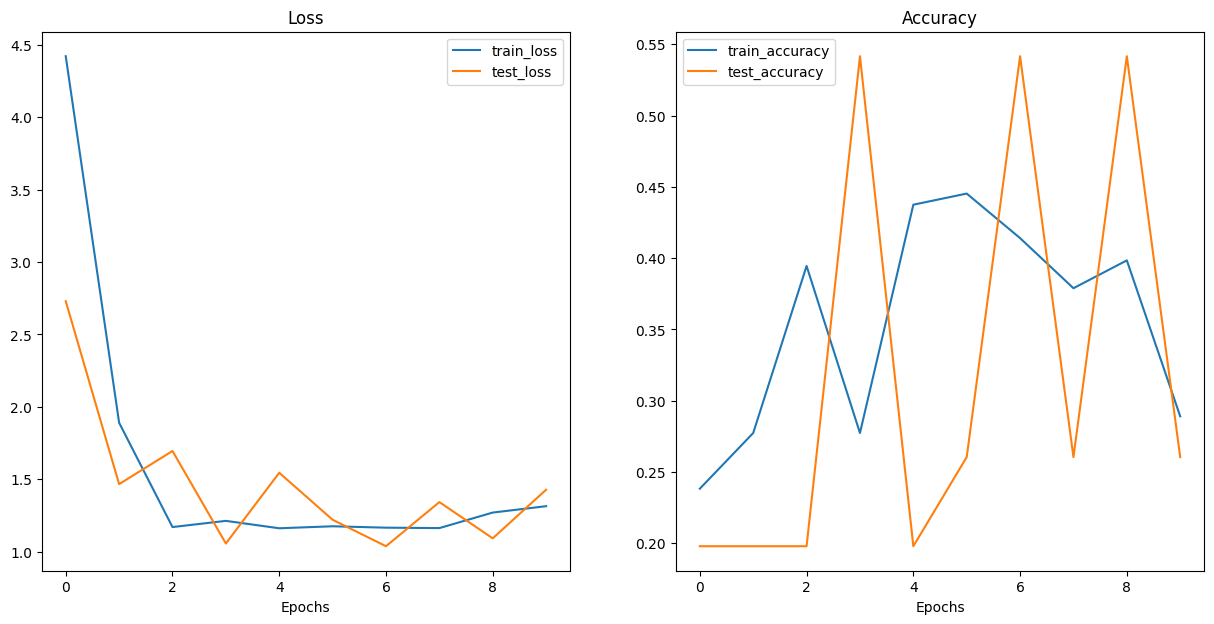

In [9]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# compiled_vit = torch.compile(vit)

results = train(
            model=vit,
            # model=compiled_vit,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            optimizer=optimizer,
            loss_fn=loss_fn,
            num_epochs=10,
            device=device
          )

plot_loss_curves(results)

In [10]:
# 역시 그냥은 잘 안되는군
# 그래서 결국 책에서는 pretrained model을 갖고 오는 걸 소개한다

# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
pretrained_vit.heads = torch.nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

# 5. Get pretrained ViT model transforms
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

# # Print a summary using torchinfo (uncomment for actual output)
torchinfo.summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9747 | train_acc: 0.4727 | test_loss: 0.5932 | test_acc: 0.8570
Epoch: 2 | train_loss: 0.3893 | train_acc: 0.9297 | test_loss: 0.3656 | test_acc: 0.9081
Epoch: 3 | train_loss: 0.2373 | train_acc: 0.9531 | test_loss: 0.2904 | test_acc: 0.9081
Epoch: 4 | train_loss: 0.1780 | train_acc: 0.9648 | test_loss: 0.2650 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.1497 | train_acc: 0.9727 | test_loss: 0.2530 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1265 | train_acc: 0.9727 | test_loss: 0.2506 | test_acc: 0.8977
Epoch: 7 | train_loss: 0.1104 | train_acc: 0.9766 | test_loss: 0.2422 | test_acc: 0.8977
Epoch: 8 | train_loss: 0.1068 | train_acc: 0.9805 | test_loss: 0.2296 | test_acc: 0.8873
Epoch: 9 | train_loss: 0.1513 | train_acc: 0.9805 | test_loss: 0.2188 | test_acc: 0.8873
Epoch: 10 | train_loss: 0.0932 | train_acc: 0.9727 | test_loss: 0.1955 | test_acc: 0.9176


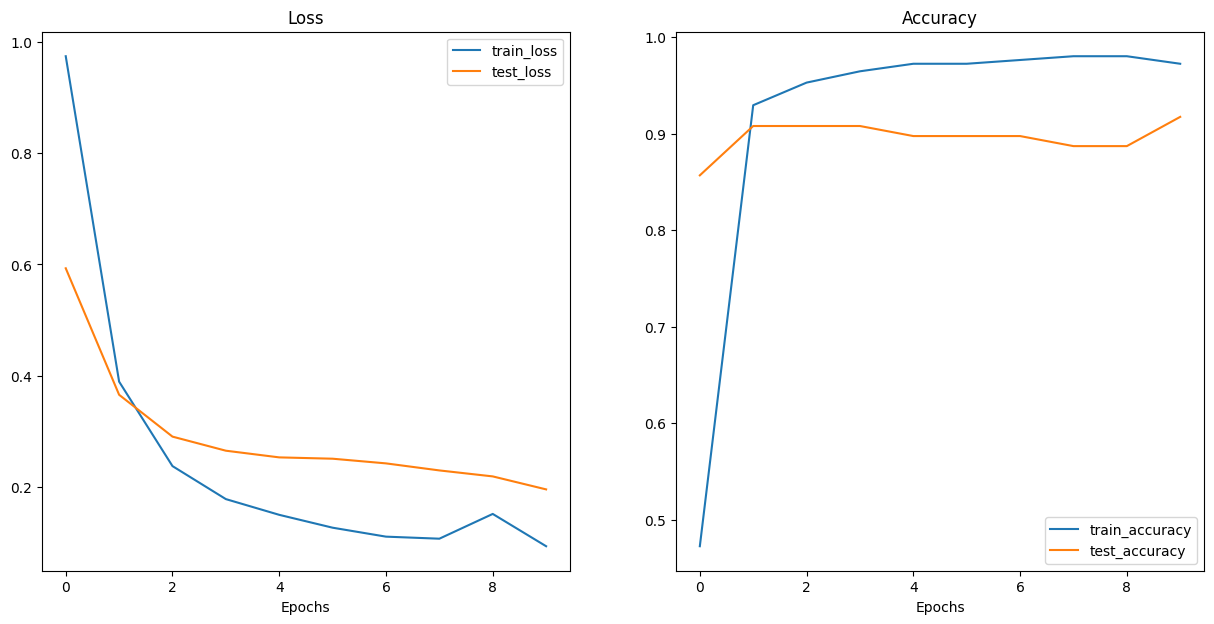

In [11]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=batch_size) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# compiled_model = torch.compile(pretrained_vit)

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      num_epochs=10,
                                      device=device)

plot_loss_curves(pretrained_vit_results)